## Training of VAE with channel patterns

In [1]:
import os
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
workdir='/home/jorge/Git_projs/VAE_SGD/'
os.chdir(workdir)
os.chdir('VAE')

### Define training samples as croppings from training image:

In [3]:
# This first block was modified from Laloy et al. (2019), Comp. Geosc.
from PIL import Image
from PIL.Image import FLIP_LEFT_RIGHT

def image_to_tensor(img):
#    tensor = np.array(img).transpose( (2,0,1) )
#    tensor = tensor / 128. - 1.
    i_array=np.array(img)
    if len(i_array.shape)==2:
        i_array=i_array.reshape((i_array.shape[0],i_array.shape[1],1))
    tensor = i_array.transpose( (2,0,1) )
    tensor = tensor / 255.
    return tensor


def tensor_to_2Dimage(tensor):
    img = np.array(tensor).transpose( (1,2,0) )
    img = (img + 1.) * 128.
    return np.uint8(img)
    

def get_texture2D_iter(folder, npx=128, npy=128,batch_size=64, \
                     filter=None, mirror=False, n_channel=1):
    HW1    = npx
    HW2    = npy
    imTex = []
    files = os.listdir(folder)
    for f in files:
        name = folder + f
        try:
            img = Image.open(name)
            imTex += [image_to_tensor(img)]
            if mirror:
                img = img.transpose(FLIP_LEFT_RIGHT)
                imTex += [image_to_tensor(img)]
        except:
            print("Image ", name, " failed to load!")

    while True:
        data=np.zeros((batch_size,n_channel,npx,npy))
        imgBig = imTex[0] # this constrains to one texture
        x = np.arange(0,imgBig.shape[2]-HW2)
        y = np.arange(0,imgBig.shape[1]-HW1)
        X, Y = np.meshgrid(x,y)
        mask = np.ones(X.shape,dtype=bool)
        # Input lists of the upper left corner of the truth images:
        x_upleft = [250,400,900]
        y_upleft = [250,400,900]
        for tr in range(len(x_upleft)):
            if (y_upleft[tr]-(HW1-1)<0):
                lowery=0
            else:
                lowery=y_upleft[tr]-(HW1-1)  
            if (x_upleft[tr]-(HW2-1)<0):
                lowerx=0
            else:
                lowerx=x_upleft[tr]-(HW2-1)
            mask[lowery:y_upleft[tr]+HW1,lowerx:x_upleft[tr]+HW2] = False
        x_m = X[mask]
        y_m = Y[mask]                 
        for i in range(batch_size):
            #ir = np.random.randint(len(imTex))
            #imgBig = imTex[ir]
            if HW1 < imgBig.shape[1] and HW2 < imgBig.shape[2]:
                icorner = np.random.randint(len(x_m))
                w = x_m[icorner]
                h = y_m[icorner]
                img = imgBig[:, h:h + HW1, w:w + HW2]
            else:                                               
                img = imgBig
            data[i] = img

        yield data

In [4]:
texture_dir = "ti/"
npx = 129
npy = 65
batch_size = 100
nc = 1
data_iter   = get_texture2D_iter(texture_dir, npx=npx, npy=npy,mirror=False, batch_size=batch_size,n_channel=nc)

In [5]:
# Set seed and check for GPU:
seed = 1
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [6]:
torch.cuda.is_available()

True

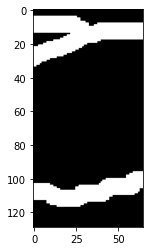

In [7]:
# Check one training sample of a batch:
fixed_x = next(iter(data_iter))
plt.imshow(fixed_x[0,0,:,:], 'Greys_r')

### Set VAE architecture:

In [8]:
dimz = 20
beta = 1e3
veps = 1.0

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 6, 2)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=12*256, z_dim=dimz):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(32), #nn.BatchNorm2d(32,momentum=0.01),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(64), #nn.BatchNorm2d(64,momentum=0.01),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(128), #nn.BatchNorm2d(128,momentum=0.01),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(256), #nn.BatchNorm2d(256,momentum=0.01),
            nn.ReLU(),
            Flatten(),
            nn.Linear(12*256,512),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(512, z_dim)
        self.fc2 = nn.Linear(512, z_dim)
        self.fc3 = nn.Linear(z_dim, 512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512,12*256),
            nn.ReLU(),
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(128), #nn.BatchNorm2d(128,momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, bias=False),
            nn.InstanceNorm2d(64), #nn.BatchNorm2d(64,momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, bias=False),
            nn.InstanceNorm2d(32), #nn.BatchNorm2d(32,momentum=0.01),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=2, bias=False),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size(), device=device)
        z = mu + std * esp * veps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, z, mu, logvar

### Estimating VAE parameters:

In [10]:
# Create model object:
image_channels = nc
model = VAE(image_channels=image_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def loss_fn(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta*KLD, MSE, KLD

In [12]:
epochs = 100

model.train()

for epoch in range(epochs):
    for idx, images in enumerate(data_iter):
        if idx >= 1000:
            break
        images_device = torch.Tensor(images)
        images_device = images_device.to(device)
        recon_images, z_encoded, mu, logvar = model(images_device)
        loss, mse, kld = loss_fn(recon_images, images_device, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if idx%100 == 0:
    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                          epochs, loss.item()/batch_size, mse.item()/batch_size, kld.item()/batch_size)
    print(to_print)

Epoch[1/100] Loss: 402.602 369.641 0.033
Epoch[2/100] Loss: 364.146 330.469 0.034
Epoch[3/100] Loss: 322.947 289.094 0.034
Epoch[4/100] Loss: 309.731 275.179 0.035
Epoch[5/100] Loss: 314.927 280.137 0.035
Epoch[6/100] Loss: 308.025 272.805 0.035
Epoch[7/100] Loss: 278.883 244.629 0.034
Epoch[8/100] Loss: 294.254 259.327 0.035
Epoch[9/100] Loss: 306.751 272.015 0.035
Epoch[10/100] Loss: 264.302 229.021 0.035
Epoch[11/100] Loss: 280.061 245.483 0.035
Epoch[12/100] Loss: 260.760 225.126 0.036
Epoch[13/100] Loss: 251.416 216.238 0.035
Epoch[14/100] Loss: 274.888 239.391 0.035
Epoch[15/100] Loss: 259.961 225.001 0.035
Epoch[16/100] Loss: 254.511 219.818 0.035
Epoch[17/100] Loss: 262.763 226.845 0.036
Epoch[18/100] Loss: 260.190 224.670 0.036
Epoch[19/100] Loss: 253.775 218.880 0.035
Epoch[20/100] Loss: 246.497 210.403 0.036
Epoch[21/100] Loss: 238.424 203.121 0.035
Epoch[22/100] Loss: 242.933 206.667 0.036
Epoch[23/100] Loss: 237.619 201.577 0.036
Epoch[24/100] Loss: 226.484 191.416 0.035
E

### Assessment of trained VAE:

In [13]:
model.eval() # sets to eval mode, e.g. changes behavior of normalization layers.

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
    (12): Flatten()
    (13): Linear(in_features=3072, out_features=512, bias=True)
    (14): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=20, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (fc3): Line

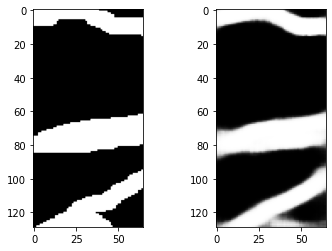

In [15]:
# Check reconstruction of one image of a batch.
xest = images
fig, ax = plt.subplots(1,2)
indt = 4 # batch index of image
ax[0].imshow(xest[indt,0,:,:], cmap='Greys_r')
imgtens = torch.Tensor(xest)
zen,mn,vari = model.encode(imgtens.to(device))
recon_x = model.decode(mn)
recon_x = recon_x.cpu().detach().numpy()
ax[1].imshow(recon_x[indt,0,:,:], cmap='Greys_r')

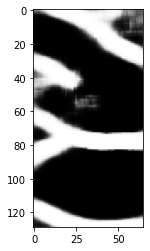

In [17]:
# Check generation of one image:
z_new = 1.0*torch.randn(1,dimz, dtype=torch.float, device=device)
x_new = model.decode(z_new)
fig,ax = plt.subplots()
ax.imshow(x_new.cpu().detach().numpy()[0,0,:,:], cmap='Greys_r')

In [18]:
# Encode 2*batch_size samples to check for distribution in latent space:
test_x1 = torch.Tensor(fixed_x)
test_x1 = test_x1.to(device)
test_x2 = torch.Tensor(images)
test_x2 = test_x2.to(device)
z_p1, _, _ = model.encode(test_x1)
z_p2, _, _ = model.encode(test_x2)

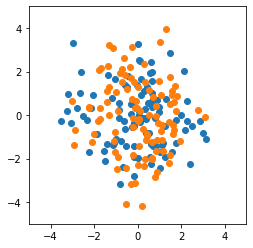

In [19]:
dim1 = 0
dim2 = 3
z_np1 = z_p1.cpu().detach().numpy()
z_np2 = z_p2.cpu().detach().numpy()
plt.scatter(z_np1[:,dim1],z_np1[:,dim2])
plt.scatter(z_np2[:,dim1],z_np2[:,dim2])
plt.axis([-5, 5, -5, 5])
plt.gca().set_aspect('equal', adjustable='box')

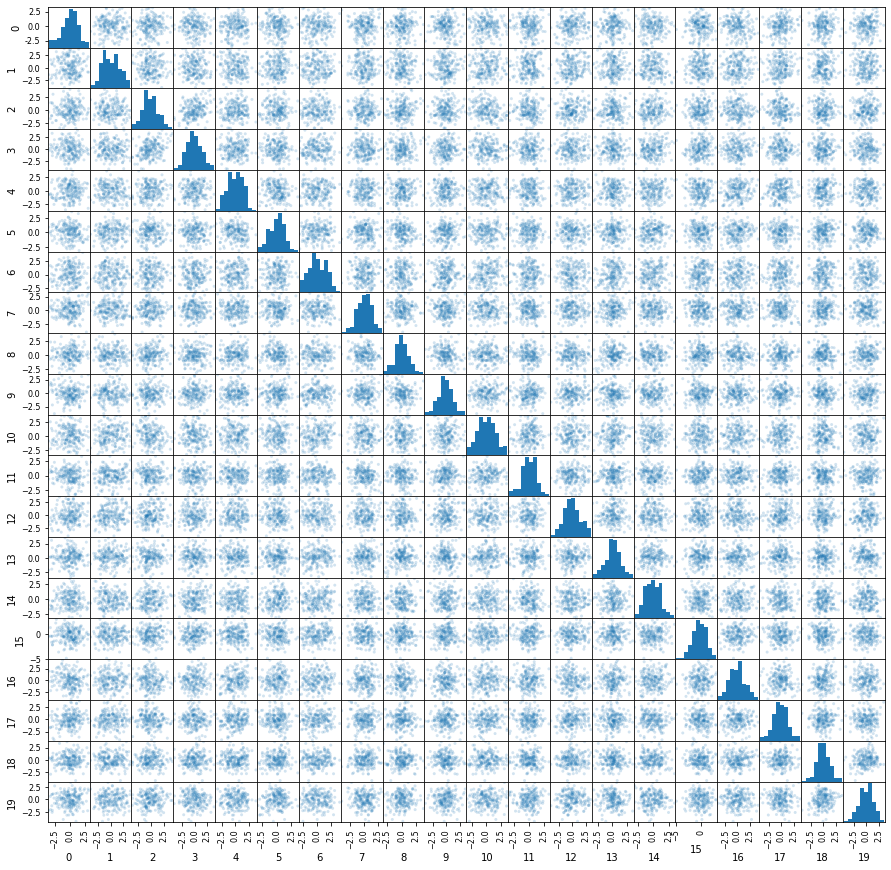

In [21]:
from pandas.plotting import scatter_matrix
import pandas as pd
df = pd.DataFrame(np.row_stack((z_np1,z_np2)))
scatter_matrix(df, alpha = 0.2, figsize = (15, 15), diagonal = 'hist')
plt.show()

Text(0.5, 1.0, '$g_\\theta(\\mathbf{z}^{(2)})$')

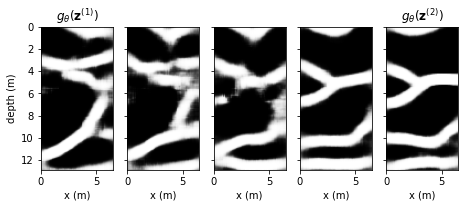

In [23]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

z_new1 = 1.0*torch.randn(1,dimz, dtype=torch.float, device=device)
z_new2 = 1.0*torch.randn(1,dimz, dtype=torch.float, device=device)
img1 = model.decode(z_new1)#torch.Tensor(fixed_x[5:6,0:1,:,:])
img2 = model.decode(z_new2)#torch.Tensor(fixed_x[6:7,0:1,:,:])

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

#plt.rc('text', usetex=False)

fig, axs = plt.subplots(1,5, figsize=(7.48, 3))
fig.subplots_adjust(hspace = .5, wspace= 0.2)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, img1, img2)#digits[7][0], digits[1][0])
   
    inter_image = inter_image.clamp(0,1)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray', origin='upper', extent=[0,6.5,12.9,0])
    #axs[ind].set_title('lambda='+str(round(l,2)))
    if ind > 0: axs[ind].set_yticklabels('')
    axs[ind].set_xlabel(r'x (m)')

axs[0].set_title(r'$g_\theta(\mathbf{z}^{(1)})$')
axs[0].set_ylabel(r'depth (m)')
axs[-1].set_title(r'$g_\theta(\mathbf{z}^{(2)})$')

In [24]:
#fig.tight_layout()
#fig.savefig('interpolation_lats.svg',dpi=300)

In [25]:
# save model state
torch.save(model.state_dict(), 'VAE_inMSEeps100r1e3.pth')

In [26]:
# Setup trasversal latent plotting
tsteps = 6
tras_lat = np.linspace(-3.0,3.0,tsteps)
#z_init = 1.0*torch.randn([1, 20]).to(device)
z_init = 1.0*torch.zeros([1, 20]).to(device)

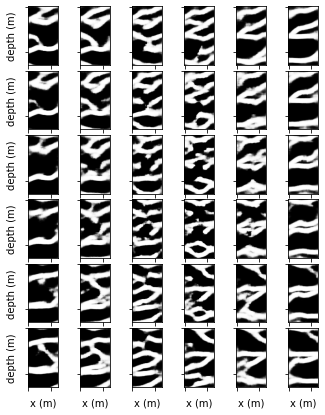

In [27]:
# Trasversal latent plotting
dim1 = 0
dim2 = 1
z_new = torch.clone(z_init)
fig, axs = plt.subplots(tsteps,tsteps, figsize=(5.51, 7))
fig.subplots_adjust(hspace = 0.1, wspace= 0.1)
for i in range(tsteps):
    z_new[0,dim1] = tras_lat[i]
    axs[i,0].set_ylabel('depth (m)')
    for j in range(tsteps):
        z_new[0,dim2] = tras_lat[j]
        x_new = model.decode(z_new)
        axs[i,j].imshow(x_new.cpu().detach().numpy()[0,0,:,:], cmap='Greys_r')
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticklabels([])
        if i==(tsteps-1): axs[i,j].set_xlabel('x (m)')

In [28]:
#fig.tight_layout()
#fig.savefig('traverse_lats.svg',dpi=300)